# Run the cells below to install the plotting requirements to reproduce the figures in the paper

In [ ]:
%pip install pandas==2.0.3 
%pip install matplotlib==3.7.2
%pip install seaborn==0.12.2

In [1]:
from pathlib import Path

DATA_PATH = Path("data")
FIGURE_PATH = Path("figures")

# Example to generate runtime statistics plots for flows
- This code can be run to reproduce the performance figure in the paper
- See "hyperspectral_boxplot.pdf" and "spatiotemporal_boxplot.pdf" in the "figures" folder

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser
from collections import defaultdict
import pickle

plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 20

class FlowInfoDataClass:
    def __init__(self):
        self.flow_id = None
        self.flow_scope = None
        self.flow_runs = []
        self.flow_order = []
        self.flow_logs = {}
        self.action_logs = {}


def get_timing_data(data: FlowInfoDataClass) -> pd.DataFrame:
    """Build dataframe containing timing information for each step in the flow
    along with the active task time, overhead, and total flow execution time."""

    timing_data = defaultdict(list)

    for run in data.flow_runs:

        task_time = 0.0

        # Find the runtime of each task within the flow
        for task in run['details']['output'].keys():
            # Skip the input task data since it's not a task
            # Publishv2Ingest always runs in 0 seconds
            if task in ["input", "Publishv2Ingest"]:
                continue

            # Get the start and end times for the task
            start_time_str = run['details']['output'][task]['start_time']
            task_data = run['details']['output'][task]
            if task == "Transfer":
                # Note: for transfer tasks, can also get: effective_bytes_per_second
                completion_time_str = task_data["details"]['completion_time']
            elif task == "Publishv2Ingest":
                completion_time_str = task_data["details"]['completion_date']
            else:
                completion_time_str = task_data['completion_time']

            start_time = dateutil.parser.parse(start_time_str.split('+')[0])
            completion_time = dateutil.parser.parse(completion_time_str.split('+')[0])

            t_total = (completion_time - start_time).total_seconds()
            # Some tasks completion_time don't have microseconds so the start time is greater
            t_total = max(t_total, 0.0)
            task_time += t_total

            timing_data[task].append(t_total)

        # Get the total runtime of the flow
        f_start = dateutil.parser.parse(run['start_time'])
        f_end = dateutil.parser.parse(run['completion_time'])
        f_total = (f_end - f_start).total_seconds()
        
        # Get the total runtime of the active tasks
        timing_data['Active'].append(task_time)
        
        # Get the flow overhead (i.e., time not spent actively running tasks)
        timing_data["Overhead"].append(f_total - task_time)

        # Add the total flow runtime
        timing_data['Total'].append(f_total)
        
    timing_df = pd.DataFrame(timing_data)
    return timing_df

def plot_boxplot(data: pd.DataFrame) -> None:
    """Create a box and whisker plot."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data)
    plt.ylabel('Time (s)')
    plt.xticks(rotation=45)
    plt.grid(True)

    # Add transparency to boxplot boxes
    for patch in plt.gca().patches:
        patch.set_alpha(0.7)

    plt.tight_layout()

        Transfer    Analysis  Publication      Active   Overhead       Total
count  72.000000   72.000000    72.000000   72.000000  72.000000   72.000000
mean   10.932426   10.982367     4.285747   26.200539  21.253055   47.453594
std     0.372456   26.096369     1.688468   26.290603   6.642749   27.548119
min    10.346827    3.064879     3.147762   17.056018  10.497852   29.151330
25%    10.622470    3.559780     3.258871   18.223015  17.041406   36.423785
50%    10.904214    4.427509     3.580570   19.422847  19.499208   39.891170
75%    11.236781    6.679052     4.354785   22.420481  24.653797   45.928132
max    11.910999  134.807630    10.756497  149.843216  46.392676  181.401762
Median Overhead: 19.499208000000003
Median Overhead Percent: 0.4920743862591883


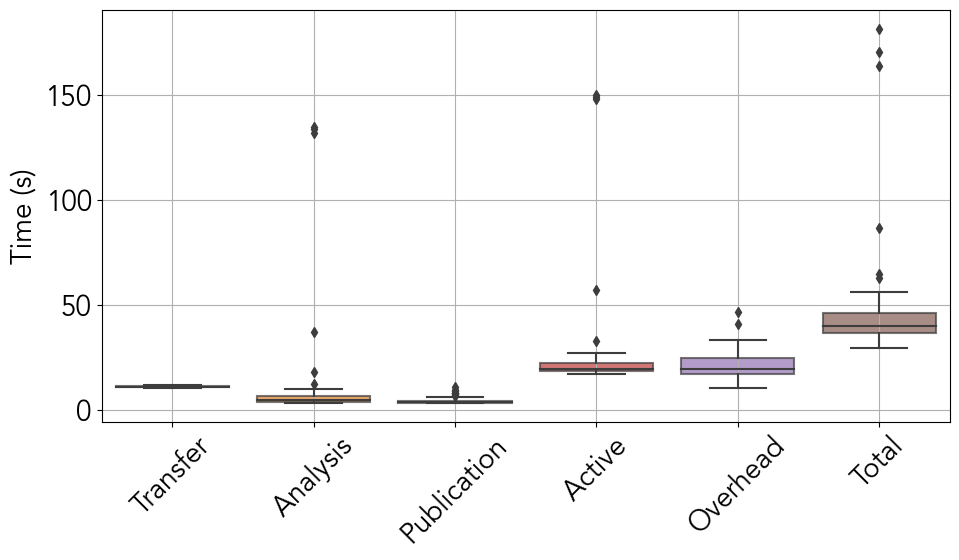

In [3]:
# Hyperspectral flow
with open(DATA_PATH / "performance_58175c8f-e94d-4f7e-b272-aff116bf86b3.pkl", "rb") as f:
    data = pickle.load(f)

timing_df = get_timing_data(data)
timing_df.rename(columns={"HyperspectralImageTool": "Analysis"}, inplace=True)
timing_df.rename(columns={"Publishv2GatherMetadata": "Publication"}, inplace=True)
print(timing_df.describe())
#timing_df.hist(figsize=(10, 10))

print("Median Overhead:", np.median(timing_df.Overhead))
print("Median Overhead Percent:", np.median(timing_df.Overhead / timing_df.Total))

# Create a box and whisker plot
plot_boxplot(timing_df)
plt.savefig(FIGURE_PATH / "hyperspectral_boxplot.pdf", bbox_inches="tight", dpi=600)
plt.show()

# timing_df["Overhead_pct"] = timing_df.Overhead / timing_df.FlowTotal
# timing_df["Overhead_pct"].hist()

         Transfer   Analysis  Publication      Active   Overhead       Total
count   18.000000  18.000000    18.000000   18.000000  18.000000   18.000000
mean   118.140784  43.517992    17.845095  179.503872  44.566669  224.070541
std      6.378009   9.649530     5.529005   14.623391  17.254268   21.220692
min    111.920500  34.480393     9.993954  163.067952  20.238423  195.630991
25%    112.410824  37.670863    16.585701  169.277912  31.704745  207.702819
50%    114.393772  40.527507    16.978836  174.008855  45.192261  219.291088
75%    124.277060  45.354623    17.457138  184.220257  57.963453  237.335999
max    128.755162  72.531883    34.163539  214.230183  72.950076  274.346484
Median Overhead: 45.19226149999999
Median Overhead Percent: 0.21079883178861486


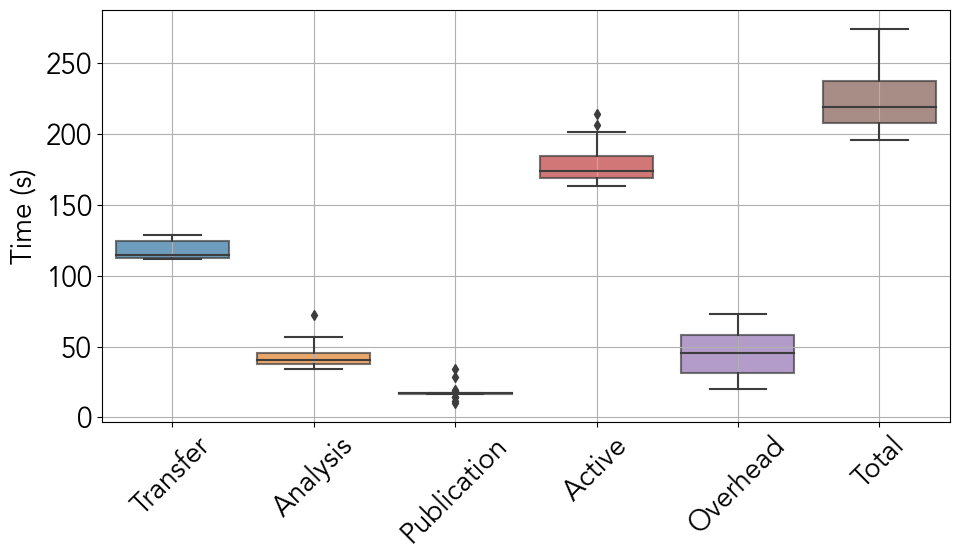

In [4]:
# Spatiotemporal flow
with open(DATA_PATH / "performance_49af5d02-6d4d-4bf9-9666-813a9f2e106f.pkl", "rb") as f:
    data = pickle.load(f)

timing_df = get_timing_data(data)
timing_df.rename(columns={"TemporalImageTool": "Analysis"}, inplace=True)
timing_df.rename(columns={"Publishv2GatherMetadata": "Publication"}, inplace=True)
print(timing_df.describe())
#timing_df.hist(figsize=(10, 10))

print("Median Overhead:", np.median(timing_df.Overhead))
print("Median Overhead Percent:", np.median(timing_df.Overhead / timing_df.Total))


# Create a box and whisker plot
plot_boxplot(timing_df)
plt.savefig(FIGURE_PATH / "spatiotemporal_boxplot.pdf", bbox_inches="tight", dpi=600)
plt.show()

# timing_df["Overhead_pct"] = timing_df.Overhead / timing_df.FlowTotal
# timing_df["Overhead_pct"].hist()

# Example for parsing Globus Compute logs
- Requires having a database file with the internal logs
- Enables you to obtain the execution time of each task

In [5]:
import sqlite3
import numpy as np
import pandas as pd

# Create your connection.
cnx = sqlite3.connect(DATA_PATH / 'picoprobe_task_data.db')

# Load the logs
df = pd.read_sql_query("SELECT * FROM transitions", cnx)

# See the types of log messages
print("Log types:", np.unique(df["message"]))

# Run the code cells above to initialize data.flow_runs
tgid = data.flow_runs[0]['details']['output']['TemporalImageTool']['action_id']
task_df = df[df['task_group_uuid'] == tgid.replace("tg_", "")]

t_es = task_df[task_df['message'] == "execution-start"]['state_time'].values[0]
t_ee = task_df[task_df['message'] == "execution-end"]['state_time'].values[0]

print("Execution time: ", (t_ee - t_es) / 1000000000)

t_rec = task_df[task_df['message'] == "received"]['state_time'].values[0]
t_ret = task_df[task_df['message'] == "result-received"]['state_time'].values[0]

print("Total time: ", (t_ret - t_rec) / 1000000000)

df.head()

Log types: ['execution-end' 'execution-start' 'received' 'result-received' 'running'
 'user_fetched' 'waiting-for-launch' 'waiting-for-nodes']
Execution time:  31.65947266
Total time:  31.714072342


,task_uuid,message,state_time,user_id,task_group_uuid,actor,endpoint_uuid,function_uuid,container_uuid,asctime
0,4e12c465-ed3c-40f8-b580-4a750f5b9ead,waiting-for-launch,1692634361261815531,1432,38bbe657-1129-41c2-824a-51b12e63f318,interchange,d8e16504-eaab-44b6-aa56-ff7d1b6040a3,f4e00946-240f-48a5-bb7d-9acb474098a0,None,"2023-08-21 16:12:51,847"
1,4e12c465-ed3c-40f8-b580-4a750f5b9ead,waiting-for-nodes,1692634361252000313,1432,38bbe657-1129-41c2-824a-51b12e63f318,interchange,d8e16504-eaab-44b6-aa56-ff7d1b6040a3,f4e00946-240f-48a5-bb7d-9acb474098a0,None,"2023-08-21 16:12:51,845"
2,fbb2b0e5-7dbf-4d29-8759-2206dba214bf,waiting-for-launch,1692634356217450521,1432,8413a01e-81a2-4482-a8ac-31b2342397ab,interchange,d8e16504-eaab-44b6-aa56-ff7d1b6040a3,10fc7474-3cda-474f-b6c9-8eb64109d6c8,None,"2023-08-21 16:12:51,841"
3,fbb2b0e5-7dbf-4d29-8759-2206dba214bf,waiting-for-nodes,1692634356212340239,1432,8413a01e-81a2-4482-a8ac-31b2342397ab,interchange,d8e16504-eaab-44b6-aa56-ff7d1b6040a3,10fc7474-3cda-474f-b6c9-8eb64109d6c8,None,"2023-08-21 16:12:51,839"
4,4e12c465-ed3c-40f8-b580-4a750f5b9ead,user_fetched,1692634364457647306,1432,38bbe657-1129-41c2-824a-51b12e63f318,web-service,d8e16504-eaab-44b6-aa56-ff7d1b6040a3,f4e00946-240f-48a5-bb7d-9acb474098a0,None,"2023-08-21 16:12:44,457"


# Generates a plot showin median runtime of the flow
- This plot was not used in the paper since the boxplot was more informative

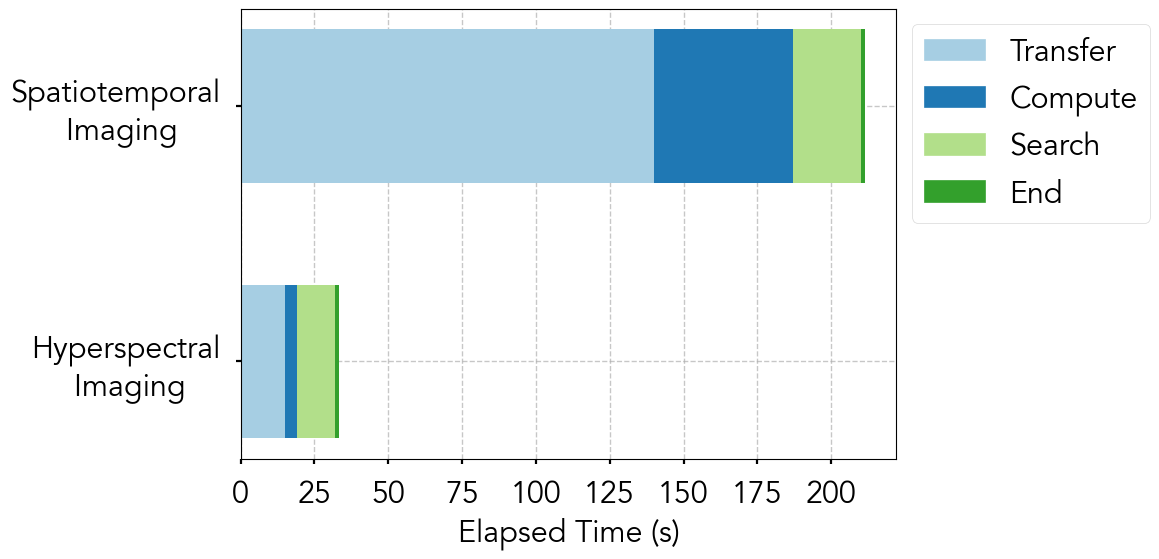

In [6]:
import matplotlib.pyplot as plt
# import seaborn as sns  
# sns.set_style("whitegrid")
with plt.style.context("seaborn-poster"):
    plt.rcParams["font.family"] = "avenir"
    # Sample data
    end_delta = 1.5
    tasks = [
        'Hyperspectral\nImaging    ',
        'Spatiotemporal\nImaging     '
    ]
    subtask_names = ["Transfer", "Compute", "Search", "End"]

    # Manually enter start and stop times for each component
    subtasks = [
        [('Transfer', 0, 15), ('Compute', 15, 19), ('Search', 19, 32), ('End', 32, 32 + end_delta)],
        [('Transfer', 0, 140), ('Compute', 140, 187), ('Search', 187, 210), ('End', 210, 210 + end_delta)],
    ]

    # Colors for task components
    colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c']

    # Create a horizontal bar chart with subtasks
    plt.figure(figsize=(12, 6))

    # Add grid lines
    plt.grid(True, linestyle='--', linewidth=1, alpha=0.7, zorder=1)

    y_positions = [0.55, 0.6]  # Adjusted y-positions to bring the bars closer
    for i, (y_position, task, subtask_list) in enumerate(zip(y_positions, tasks, subtasks)):
        for (subtask, start, end), color in zip(subtask_list, colors):
            # Plot the subtask bars
            plt.barh(y_position, end - start, height=0.03, left=start, color=color, label=subtask, zorder=2)

    # Set x-axis label
    plt.xlabel('Elapsed Time (s)', fontsize=22)

    # Set y-axis label
    plt.yticks(y_positions, tasks, fontsize=22)  # Setting y-ticks for task labels
    plt.xticks(fontsize=22)

    # Create the legend with unique handles and labels
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    plt.legend(legend_handles, subtask_names, loc='upper left', bbox_to_anchor=(1, 1), fontsize=22)
    
    plt.tight_layout()
    #plt.savefig(FIGURE_PATH / "median-flow-runtime.pdf", dpi=600, bbox_inches="tight")
    plt.show()